# Inference script

Da usare per:
- creare gli output video
- testare nuovi metodi di inferenza
- calcolare metrics di un modello salvato
- testare nuovi metodi per valutare le preds

Nel config file, modificare i parametri nella "testing" section

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
import os
import time

import numpy as np
import pandas as pd
from torch import nn
import torch

from matplotlib import pyplot as plt
import napari

from data.datasets import SparkDataset
from data.data_processing_tools import (
    dict_to_int_mask,
    get_event_instances_class,
    process_raw_predictions,
)

from evaluation.metrics_tools import (
    get_metrics_from_summary,
    get_score_matrix,
    get_matches_summary,
    compute_iou,
    get_df_summary_events,
    get_df_metrics,
)

from utils.visualization_tools import (
    get_discrete_cmap,
    get_labels_cmap,
    get_annotations_contour,
)

from utils.in_out_tools import write_videos_on_disk
from utils.training_inference_tools import get_preds
from utils.training_script_utils import init_model

from config import TrainingConfig, config

logger = logging.getLogger(__name__)

# import unet_openai
# from torch.cuda.amp import GradScaler



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [3]:
#################### Set trained model-specific parameters #####################

training_name = "final_model"
config_filename = "config_final_model.ini"
load_epoch = 100000

use_train_data = False
get_final_pred = True  # set to False to only compute raw predictions
testing = False  # set to False to only generate unet predictions
# set to True to also compute processed outputs and metrics
# inference_types = ['overlap', 'average', 'gaussian', 'max']
inference_types = None  # set to None to use the default inference type from
# the config file


# Initialize general parameters
params = TrainingConfig(
    training_config_file=os.path.join("config_files", config_filename)
)
params.training_name = training_name
model_name = f"network_{load_epoch::06d}.pth"


if testing:
    get_final_pred = True

if get_final_pred:
    debug = True

# Configure output folder

output_folder = "trainings_validation"  # Same folder for train and test preds
os.makedirs(output_folder, exist_ok=True)

# Subdirectory of output_folder where predictions are saved.
# Change this to save results for same model with different inference
# approaches.
# output_name = training_name + "_step=2"
output_name = params.training_name

save_folder = os.path.join(output_folder, output_name)
os.makedirs(save_folder, exist_ok=True)
logger.info(
    f"Annotations and predictions will be saved on '{save_folder} + inference_type'"
)

In [6]:
logger.info(f"Processing training '{params.training_name}'...")

[15:40:11] [  INFO  ] [  __main__  ] < 1  > -- Processing training 'final_model'...


In [7]:
########################### Detect GPU, if available ###########################

params.set_device(device="auto")
params.display_device_info()

[15:40:11] [  INFO  ] [  __main__  ] < 5  > -- Using device 'cuda' with 1 GPUs


In [8]:
######################## Config dataset and UNet model #########################

logger.info(f"Processing training '{params.training_name}'...")

# Define the sample IDs based on dataset size and usage
if use_train_data:
    logger.info("Predict outputs for training data")
    if params.dataset_size == "full":
        sample_ids = [
            "01",
            "02",
            "03",
            "04",
            "06",
            "07",
            "08",
            "09",
            "11",
            "12",
            "13",
            "14",
            "16",
            "17",
            "18",
            "19",
            "21",
            "22",
            "23",
            "24",
            "27",
            "28",
            "29",
            "30",
            "33",
            "35",
            "36",
            "38",
            "39",
            "41",
            "42",
            "43",
            "44",
            "46",
        ]
    elif params.dataset_size == "minimal":
        sample_ids = ["01"]
else:
    logger.info("Predict outputs for testing data")
    if params.dataset_size == "full":
        sample_ids = ["05", "10", "15", "20", "25", "32", "34", "40", "45"]
    elif params.dataset_size == "minimal":
        sample_ids = ["34"]

# Check if the specified dataset path is a directory
assert os.path.isdir(params.dataset_path), f'"{params.dataset_path}" is not a directory'
logger.info(f"Using {params.dataset_path} as dataset root path")

[15:40:11] [  INFO  ] [  __main__  ] < 18 > -- Predict outputs for testing data
[15:40:11] [  INFO  ] [  __main__  ] < 27 > -- Using C:\Users\dotti\sparks_project\data\sparks_dataset as dataset root path


In [10]:
### Configure UNet ###
network = init_model(params=params)
network = nn.DataParallel(network).to(params.device)

### Load UNet model ###

# Path to the saved model checkpoint
models_relative_path = "runs/"
model_path = os.path.join(models_relative_path, params.training_name, model_name)

# Load the model state dictionary
logger.info(f"Loading trained model '{training_name}' at epoch {load_epoch}...")
network.load_state_dict(torch.load(model_path, map_location=params.device))
network.eval()

[15:40:11] [  INFO  ] [  __main__  ] < 34 > -- Loading trained model 'final_model' at epoch 100000...
[15:40:11] [  INFO  ] [unet.trainer] <131 > -- Loading 'runs/final_model\network_100000.pth'...


In [11]:
############################# Run samples in UNet ##############################

input_movies = {}
ys = {}
ys_instances = {}
preds_dict = {}
if get_final_pred:
    preds_instances = {}
    preds_segmentation = {}

for sample_id in sample_ids:
    logger.debug(f"Processing sample {sample_id}...")
    start = time.time()
    ### Create dataset ###
    testing_dataset = SparkDataset(
        base_path=params.dataset_path,
        sample_ids=[sample_id],
        testing=testing,
        params=params,
        gt_available=True,
        inference=params.inference,
    )

    logger.info(
        f"\tTesting dataset of movie {testing_dataset.video_name} "
        f"contains {len(testing_dataset)} samples."
    )

    logger.info(f"\tProcessing samples in UNet...")
    # ys and preds are numpy arrays
    input_movies[sample_id], ys[sample_id], preds_dict[sample_id] = get_preds(
        network=network,
        test_dataset=testing_dataset,
        params=params,
        inference_types=inference_types,
        return_dict=True,
    )

    if testing:
        # get labelled event instances, for validation
        # ys_instances is a dict with classified event instances, for each class
        ys_instances[sample_id] = get_event_instances_class(
            event_instances=testing_dataset.events,
            class_labels=ys[sample_id],
            shift_ids=True,
        )
        # remove ignored events entry from ys_instances
        ys_instances[sample_id].pop("ignore", None)

        # get pixels labelled with 4
        # ignore_mask = np.where(ys == 4, 1, 0)

    if get_final_pred:
        ######################### get processed output #########################

        logger.debug("Getting processed output (segmentation and instances)")

        # get predicted segmentation and event instances
        if inference_types is None or len(inference_types) == 1:
            (
                preds_instances[sample_id],
                preds_segmentation[sample_id],
                _,
            ) = process_raw_predictions(
                raw_preds_dict=preds_dict[sample_id],
                input_movie=input_movies[sample_id],
                training_mode=False,
                debug=debug,
            )
        else:
            # initialize empty dicts what will be indexed by inference type
            preds_instances[sample_id], preds_segmentation[sample_id] = {}, {}

            for i in inference_types:
                logger.debug(f"\tProcessing inference type {i}...")
                raw_preds_dict = {
                    "sparks": preds_dict[sample_id][i][1],
                    "puffs": preds_dict[sample_id][i][3],
                    "waves": preds_dict[sample_id][i][2],
                }
                (
                    preds_instances[sample_id][i],
                    preds_segmentation[sample_id][i],
                    _,
                ) = process_raw_predictions(
                    preds_dict=raw_preds_dict,
                    input_movie=input_movies[sample_id],
                    training_mode=False,
                    debug=debug,
                )

    if not get_final_pred:
        logger.info(
            f"\tTime to process sample {sample_id} in UNet: {time.time() - start:.2f} seconds."
        )
    else:
        logger.info(
            f"\tTime to process sample {sample_id} in UNet + post-processing: {time.time() - start:.2f} seconds."
        )

    ### Save preds on disk ###
    logger.info(f"\tSaving annotations and predictions...")

    video_name = f"{str(params['load_epoch'])}_{testing_dataset.video_name}"

    if inference_types is None or len(inference_types) == 1:
        write_videos_on_disk(
            training_name=output_name,
            video_name=video_name,
            path=save_folder,
            preds=[
                None,
                preds_dict[sample_id]["sparks"],
                preds_dict[sample_id]["waves"],
                preds_dict[sample_id]["puffs"],
            ],
            ys=ys[sample_id],
        )
    else:
        for i in inference_types:
            write_videos_on_disk(
                training_name=output_name,
                video_name=video_name,
                path=os.path.join(save_folder, "inference_" + i),
                preds=[
                    None,
                    preds_dict[sample_id][i]["sparks"],
                    preds_dict[sample_id][i]["waves"],
                    preds_dict[sample_id][i]["puffs"],
                ],
                ys=ys[sample_id],
            )

logger.info(f"DONE")

[15:40:15] [ DEBUG  ] [  __main__  ] < 12 > -- Processing sample 34...
[15:40:15] [WARNING ] [tifffile.tifffile] <16549> -- TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
[15:40:15] [WARNING ] [tifffile.tifffile] <16549> -- TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
[15:40:15] [ DEBUG  ] [  datasets  ] <293 > -- Added padding of 24 frames to video with unsuitable duration
[15:40:15] [  INFO  ] [  __main__  ] < 36 > -- 	Testing dataset of movie 34 contains 22 samples.
[15:40:15] [  INFO  ] [  __main__  ] < 41 > -- 	Processing samples in UNet...
[15:40:25] [ DEBUG  ] [  __main__  ] < 68 > -- Getting processed output (segmentation and instances)
[15:40:25] [ DEBUG  ] [data_processing_tools] <459 > -- Events detection threshold: 0.498
[15:40:35] [ DEBUG  ] [data_processing_tools] <525 > -- Number of sparks detected by nonmaxima suppression: 61
[15:40:36] [ D

## Visualize preds with Napari

- load given training at given iteration (testing section of config file) and visualize predictions using Napari
- (idea is to check if it makes sense to stop the training earlier)
- adapt dataset size (& other params) in config file prior to execute code above if necessary

Trainings already checked with this method:
- final_model (minimal dataset, only movie 34)
    - 10K; 20K; 30K; 40K: too many sparks, does not make sense (>2K after correction)
    - 50K: too many sparks, does not make sense (>1K after correction)
    - 60K: 72 sparks before correction/82 sparks after correction
    - 70K: 71/78 -> does not change much from 60K aesthetically
    - 80K: 53/55 -> same; in the end what matters is to chose the best metrics (I believe)
    - 90K: 51/55 -> same
    - 100K: 61/63 -> same

In [20]:
cmap = get_discrete_cmap(name="gray", lut=16)

In [29]:
preds_classes = {}

In [57]:
sample_id = sample_ids[0]

# get contours of annotations, for visualization
ys_contours = get_annotations_contour(annotations=ys[sample_id], contour_val=2)

# get predicted segmentation and event instances
# _, raw_sparks, raw_waves, raw_puffs = preds[sample_id]
# preds_events = preds_instances[sample_id]

preds_classes[params["load_epoch"]] = (
    preds_segmentation[sample_id]["sparks"]
    + 3 * preds_segmentation[sample_id]["puffs"]
    + 2 * preds_segmentation[sample_id]["waves"]
)

In [ ]:
viewer = napari.Viewer()
viewer.add_image(input_movies[sample_id], name="raw", colormap=("colors", cmap))
viewer.add_labels(ys_contours, name="gt", opacity=0.5, color=get_labels_cmap())

# viewer.add_image(raw_sparks, name='raw_sparks')
# viewer.add_image(raw_waves, name='raw_waves')
# viewer.add_image(raw_puffs, name='raw_puffs')
for epoch in preds_classes.keys():
    viewer.add_labels(
        preds_classes[epoch],
        name=f"preds_{epoch}",
        opacity=0.3,
        color=get_labels_cmap(),
    )

[15:10:08] [WARNING ] [   vispy    ] <234 > -- QWindowsWindow::setGeometry: Unable to set geometry 2172x1364+1580+522 (frame: 2194x1420+1569+477) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY17". Resulting geometry: 2606x1566+1582+529 (frame: 2628x1622+1571+484) margins: 11, 45, 11, 11 minimum size: 374x558 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=770,1172 maxtrack=0,0)


[15:10:08] [WARNING ] [   vispy    ] <234 > -- QWindowsWindow::setGeometry: Unable to set geometry 3456x2610+1582+530 (frame: 3478x2666+1571+485) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY17". Resulting geometry: 3456x1566+1582+530 (frame: 3478x1622+1571+485) margins: 11, 45, 11, 11 minimum size: 374x558 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=770,1172 maxtrack=0,0)
[15:10:08] [ DEBUG  ] [napari.loader] < 67 > -- ImageSlice.__init__
[15:10:08] [ DEBUG  ] [napari.loader] < 67 > -- ImageSlice.__init__
[15:10:08] [ DEBUG  ] [napari.loader] < 67 > -- ImageSlice.__init__
[15:10:08] [ DEBUG  ] [napari.loader] < 67 > -- ImageSlice.__init__
[15:10:08] [ DEBUG  ] [napari.loader] < 67 > -- ImageSlice.__init__
[15:10:08] [ DEBUG  ] [napari.loader] < 67 > -- ImageSlice.__init__
[15:10:08] [ DEBUG  ] [napari.loader] < 67 > -- ImageSlice.__init__
[15:10:08] [ DEBUG  ] [napari.loader] < 67 > -- ImageSlice.__init__
[15:10:08] [ DEBUG  ] [napari.loader] < 67 > -- ImageSlice.__init__

[15:10:17] [ DEBUG  ] [  in_n_out  ] <768 > -- Executing @injected toggle_grid(viewer: napari.viewer.Viewer) with args: (), kwargs: {}
[15:10:17] [ DEBUG  ] [  in_n_out  ] <788 > --   injecting viewer: <class 'napari.viewer.Viewer'> = Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 31.5, 255.5), zoom=2.8827297152601523, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(452.0, 247.78804346522566, -134.7551057828335), scaled=True, size=10, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 904.0, 1.0), (0.0, 64.0, 1.0), (0.0, 512.0, 1.0)), current_step=(452, 32, 256), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'raw' at 0x263b7ceb160>, <Labels layer 'gt' at 0x263b72d09d0>, <Labels layer 'preds_60000' at 0x263b736cc40>, <Labels layer 'preds_70000' at 0x263b878dd

## Compute metrics

- if considering more than one inference type:
    - `preds_instances` is a nested dict indexed first by movie id, then by inference type, and finally by class. E.g., `preds_instances['05']['overlap']['sparks']` is a numpy array of shape (500, 64, 512) with integer values denoting the events' IDs.
    - `preds_segmentation` is a nested dict indexed first by movie id, then by inference type, and finally by class e.g., `preds_segmentation['05']['overlap']['sparks']` is a numpy array of shape (500, 64, 512) with boolean values denoting the events' presence.
- if considering only one inference type: `preds_instances` and `preds_segmentation`
are the same as above, buth without the inference type index 
- `ys_instances` is a nested dict indexed by movie id and class of events containing arrays with integer values denoting the events' IDs.
- `ys` is a dict indexed by movie id with integers between 0 and 4 to denote the class of the annotated events.

In [12]:
if not testing:
    print("!!!!!!!!! THE FOLLOWING CODE WON'T WORK !!!!!!!!!")

In [14]:
# compute loss on all samples
sum_loss = 0.0  # SERVE???

In [15]:
# to unify the results for any number of inferences, transform 'preds_instances'
# and 'preds_segmentation' adding a new "nested" key 'inference_type'

if len(inference_types) == 1:
    temp_instances = {
        movie_id: {params.inference: preds_instances[movie_id]}
        for movie_id in sample_ids
    }
    temp_segmentation = {
        movie_id: {params.inference: preds_segmentation[movie_id]}
        for movie_id in sample_ids
    }

    preds_instances = temp_instances
    preds_segmentation = temp_segmentation

### Segmentation-based metrics (i.e., IoU)

In [16]:
# define the columns of the dataframe
segmentation_cols = ["inference_type", "event_type", "iou"]

In [17]:
# concatenate annotations and preds to compute segmentation-based metrics
ys_concat = []
preds_concat = {i: [] for i in inference_types}

for sample_id in sample_ids:
    ys_concat.append(ys[sample_id])

    for i in inference_types:
        # get preds segmentation as integer array with values in [0, 1, 2, 3]
        temp_preds = dict_to_int_mask(preds_segmentation[sample_id][i])
        preds_concat[i].append(temp_preds)

ys_concat = np.concatenate(ys_concat)
preds_concat = {i: np.concatenate(preds_concat[i]) for i in inference_types}

# get masks for pixels labelled with 4
ignore_concat = ys_concat == 4

In [18]:
# compute intersection over union for each inference type
# (per class, average, and as binary classification)

iou_dict = {i: {} for i in inference_types}

for i in inference_types:
    for event_type, event_label in config.classes_dict.items():
        if event_type in ["ignore", "background"]:
            continue
        class_ys = ys_concat == event_label
        class_preds = preds_concat[i] == event_label

        iou_dict[i][event_type] = compute_iou(
            ys_roi=class_ys, preds_roi=class_preds, ignore_mask=ignore_concat
        )

    # compute average iou
    iou_dict[i]["average"] = np.mean(list(iou_dict[i].values()))

    # compute binary classification iou
    iou_dict[i]["binary"] = compute_iou(
        ys_roi=ys_concat != 0, preds_roi=preds_concat[i] != 0, ignore_mask=ignore_concat
    )

In [19]:
pd.set_option("display.precision", 3)

# create dataframe where index is event type and columns are inference types
df_barplot = pd.DataFrame(iou_dict).T.T
df_barplot

,overlap,average,gaussian,max
sparks,0.195,0.202,0.201,0.185
puffs,0.181,0.177,0.178,0.202
waves,0.279,0.276,0.278,0.258
average,0.219,0.218,0.219,0.215
binary,0.339,0.334,0.337,0.327


<Axes: >

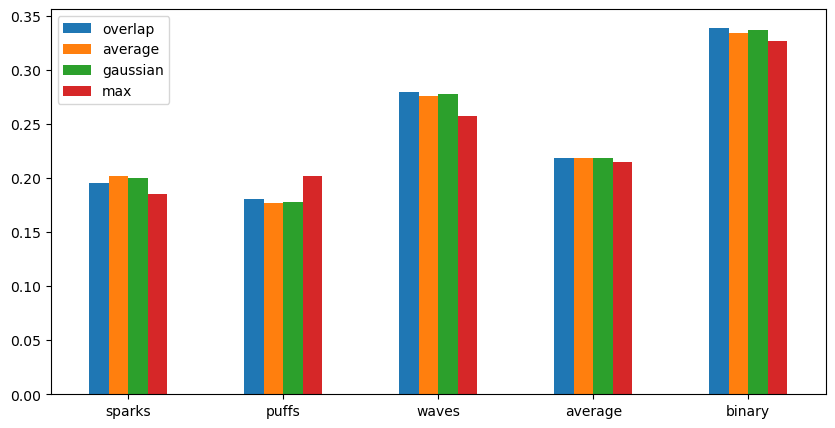

In [21]:
df_barplot.plot.bar(rot=0, figsize=(10, 5))

### Instance-based metrics

In [ ]:
ca_release_events = [
    event_type
    for event_type in config.classes_dict.keys()
    if event_type not in ["ignore", "background"]
]

In [ ]:
# sum events over all samples
preds_cat = ["tot", "tp", "ignored", "unlabeled"] + ca_release_events
ys_cat = ["tot", "tp", "undetected"] + ca_release_events

In [ ]:
# initialize dicts that will contain the results
matched_preds_ids = {i: {} for i in inference_types}
matched_ys_ids = {i: {} for i in inference_types}

for i in inference_types:
    matched_preds_ids[i]["sum"] = {}
    matched_ys_ids[i]["sum"] = {}
    for ca_event in ca_release_events:
        matched_preds_ids[i]["sum"][ca_event] = {
            cat: 0 for cat in preds_cat if cat != ca_event
        }
        matched_ys_ids[i]["sum"][ca_event] = {
            cat: 0 for cat in ys_cat if cat != ca_event
        }

for sample_id in sample_ids:
    logger.info(f"Processing sample {sample_id}...")

    # get ignore mask for this sample
    ignore_mask = ys[sample_id] == 4

    # compute pairwise scores between annotated and predicted ROIs
    # (for each inference type)
    for i in inference_types:
        logger.info(f"\tInference type {i}...")
        iomin_scores = get_score_matrix(
            ys_instances=ys_instances[sample_id],
            preds_instances=preds_instances[sample_id][i],
            ignore_mask=None,
            score="iomin",
        )

        # get ids of matched ROIs
        (
            matched_ys_ids[i][sample_id],
            matched_preds_ids[i][sample_id],
        ) = get_matches_summary(
            ys_instances=ys_instances[sample_id],
            preds_instances=preds_instances[sample_id][i],
            scores=iomin_scores,
            ignore_mask=ignore_mask,
        )

        # count number of categorized events that are necessary for the metrics
        for ca_event in ca_release_events:
            for cat in matched_ys_ids[i][sample_id][ca_event].keys():
                matched_ys_ids[i]["sum"][ca_event][cat] += len(
                    matched_ys_ids[i][sample_id][ca_event][cat]
                )

            for cat in matched_preds_ids[i][sample_id][ca_event].keys():
                matched_preds_ids[i]["sum"][ca_event][cat] += len(
                    matched_preds_ids[i][sample_id][ca_event][cat]
                )

[17:03:22] [  INFO  ] [  __main__  ] < 15 > -- Processing sample 05...
[17:03:22] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type overlap...
[17:03:37] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type average...
[17:03:53] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type gaussian...
[17:04:08] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type max...
[17:04:23] [  INFO  ] [  __main__  ] < 15 > -- Processing sample 10...
[17:04:23] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type overlap...
[17:04:29] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type average...
[17:04:34] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type gaussian...
[17:04:40] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type max...
[17:04:45] [  INFO  ] [  __main__  ] < 15 > -- Processing sample 15...
[17:04:45] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type overlap...
[17:04:54] [  INFO  ] [  __main__  ] < 23 > -- 	Inference type average...
[17:05:03] [  INFO  ] [  __main__  ] < 23 > -- 	Infer

In [ ]:
# get dict that only contains sum over all samples
tot_preds = {
    i: {
        ca_class: matched_preds_ids[i]["sum"][ca_class]["tot"]
        for ca_class in ca_release_events
    }
    for i in inference_types
}
tp_preds = {
    i: {
        ca_class: matched_preds_ids[i]["sum"][ca_class]["tp"]
        for ca_class in ca_release_events
    }
    for i in inference_types
}
ignored_preds = {
    i: {
        ca_class: matched_preds_ids[i]["sum"][ca_class]["ignored"]
        for ca_class in ca_release_events
    }
    for i in inference_types
}
unlabeled_preds = {
    i: {
        ca_class: matched_preds_ids[i]["sum"][ca_class]["unlabeled"]
        for ca_class in ca_release_events
    }
    for i in inference_types
}
tot_ys = {
    i: {
        ca_class: matched_ys_ids[i]["sum"][ca_class]["tot"]
        for ca_class in ca_release_events
    }
    for i in inference_types
}
tp_ys = {
    i: {
        ca_class: matched_ys_ids[i]["sum"][ca_class]["tp"]
        for ca_class in ca_release_events
    }
    for i in inference_types
}
undetected_ys = {
    i: {
        ca_class: matched_ys_ids[i]["sum"][ca_class]["undetected"]
        for ca_class in ca_release_events
    }
    for i in inference_types
}


metrics_all = {i: {} for i in inference_types}

# get other metrics (precision, recall, % correctly classified, % detected)
for i in inference_types:
    metrics_all[i] = get_metrics_from_summary(
        tot_preds=tot_preds[i],
        tp_preds=tp_preds[i],
        ignored_preds=ignored_preds[i],
        unlabeled_preds=unlabeled_preds[i],
        tot_ys=tot_ys[i],
        tp_ys=tp_ys[i],
        undetected_ys=undetected_ys[i],
    )

In [ ]:
# Compute same metrics but as % instad of absolute numbers
matched_preds_percent = {
    i: {ca_event: {} for ca_event in ca_release_events} for i in inference_types
}
matched_ys_percent = {
    i: {ca_event: {} for ca_event in ca_release_events} for i in inference_types
}

for i in inference_types:
    for ca_event in ca_release_events:
        for cat in matched_preds_ids[i]["sum"][ca_event].keys():
            if cat != "tot":
                matched_preds_percent[i][ca_event][cat] = (
                    matched_preds_ids[i]["sum"][ca_event][cat]
                    / matched_preds_ids[i]["sum"][ca_event]["tot"]
                    * 100
                )

        for cat in matched_ys_ids[i]["sum"][ca_event].keys():
            if cat != "tot":
                matched_ys_percent[i][ca_event][cat] = (
                    matched_ys_ids[i]["sum"][ca_event][cat]
                    / matched_ys_ids[i]["sum"][ca_event]["tot"]
                    * 100
                )

In [ ]:
print("Summary of detected events")
for i in inference_types:
    df = get_df_summary_events(
        inference_type=i,
        matched_ids=matched_preds_ids,
        matched_percent=matched_preds_percent,
        is_detected=True,
    )
    # Format the DataFrame
    styled_df = df.style.format(precision=2, na_rep="N/A")
    print(f"{i} inference")
    display(styled_df)

print("Summary of labeled events")
for i in inference_types:
    df = get_df_summary_events(
        inference_type=i,
        matched_ids=matched_ys_ids,
        matched_percent=matched_ys_percent,
        is_detected=False,
    )
    # Format the DataFrame
    styled_df = df.style.format(precision=2, na_rep="N/A")
    print(f"{i} inference")
    display(styled_df)

Summary of detected events
overlap inference


,sparks,puffs,waves,% sparks,% puffs,% waves
tot detected,398,138,4,nan,nan,nan
ignored,16,7,0,4.02,5.07,0.00
unlabeled,128,57,0,32.16,41.30,0.00
matched with labeled puffs,69,49,0,17.34,35.51,0.00
matched with labeled waves,36,12,4,9.05,8.70,100.00
matched with labeled sparks,150,18,0,37.69,13.04,0.00


average inference


,sparks,puffs,waves,% sparks,% puffs,% waves
tot detected,392,138,4,nan,nan,nan
ignored,15,6,0,3.83,4.35,0.00
unlabeled,125,55,0,31.89,39.86,0.00
matched with labeled puffs,70,46,0,17.86,33.33,0.00
matched with labeled waves,33,15,4,8.42,10.87,100.00
matched with labeled sparks,150,20,0,38.27,14.49,0.00


gaussian inference


,sparks,puffs,waves,% sparks,% puffs,% waves
tot detected,406,143,4,nan,nan,nan
ignored,20,6,0,4.93,4.20,0.00
unlabeled,133,60,0,32.76,41.96,0.00
matched with labeled puffs,70,47,0,17.24,32.87,0.00
matched with labeled waves,34,14,4,8.37,9.79,100.00
matched with labeled sparks,149,20,0,36.70,13.99,0.00


max inference


,sparks,puffs,waves,% sparks,% puffs,% waves
tot detected,427,156,4,nan,nan,nan
ignored,12,5,0,2.81,3.21,0.00
unlabeled,152,62,0,35.60,39.74,0.00
matched with labeled puffs,78,51,0,18.27,32.69,0.00
matched with labeled waves,34,19,4,7.96,12.18,100.00
matched with labeled sparks,152,23,0,35.60,14.74,0.00


Summary of labeled events
overlap


,sparks,puffs,waves,% sparks,% puffs,% waves
tot labeled,265,74,7,nan,nan,nan
undetected,92,19,1,34.72,25.68,14.29
matched with detected puffs,24,41,5,9.06,55.41,71.43
matched with detected waves,0,0,4,0.00,0.00,57.14
matched with detected sparks,152,39,6,57.36,52.70,85.71


average


,sparks,puffs,waves,% sparks,% puffs,% waves
tot labeled,265,74,7,nan,nan,nan
undetected,92,19,0,34.72,25.68,0.00
matched with detected puffs,26,39,5,9.81,52.70,71.43
matched with detected waves,0,0,4,0.00,0.00,57.14
matched with detected sparks,152,40,6,57.36,54.05,85.71


gaussian


,sparks,puffs,waves,% sparks,% puffs,% waves
tot labeled,265,74,7,nan,nan,nan
undetected,94,19,0,35.47,25.68,0.00
matched with detected puffs,26,40,5,9.81,54.05,71.43
matched with detected waves,0,0,4,0.00,0.00,57.14
matched with detected sparks,151,40,6,56.98,54.05,85.71


max


,sparks,puffs,waves,% sparks,% puffs,% waves
tot labeled,265,74,7,nan,nan,nan
undetected,91,19,0,34.34,25.68,0.00
matched with detected puffs,29,40,5,10.94,54.05,71.43
matched with detected waves,0,0,4,0.00,0.00,57.14
matched with detected sparks,153,42,6,57.74,56.76,85.71


In [ ]:
for i in inference_types:
    df = get_df_metrics(inference_type=i, metrics_all=metrics_all)
    # Set the display precision to 2 decimal places
    pd.set_option("display.precision", 2)
    # Format the DataFrame
    styled_df = df.style.format(precision=2)
    print(f"Metrics using {i} inference")
    display(styled_df)

Metrics using overlap inference


,precision,recall,correctly_classified,detected
sparks,0.39,0.57,0.59,0.65
puffs,0.37,0.55,0.66,0.74
waves,1.00,0.57,1.00,0.86
average,0.59,0.57,0.75,0.75


Metrics using average inference


,precision,recall,correctly_classified,detected
sparks,0.40,0.57,0.60,0.65
puffs,0.35,0.53,0.60,0.74
waves,1.00,0.57,1.00,1.00
average,0.58,0.56,0.73,0.80


Metrics using gaussian inference


,precision,recall,correctly_classified,detected
sparks,0.39,0.57,0.59,0.65
puffs,0.34,0.54,0.61,0.74
waves,1.00,0.57,1.00,1.00
average,0.58,0.56,0.73,0.80


Metrics using max inference


,precision,recall,correctly_classified,detected
sparks,0.37,0.58,0.58,0.66
puffs,0.34,0.54,0.57,0.74
waves,1.00,0.57,1.00,1.00
average,0.57,0.56,0.72,0.80


## Visualize other properties of data...

### Plot histograms of raw predictions

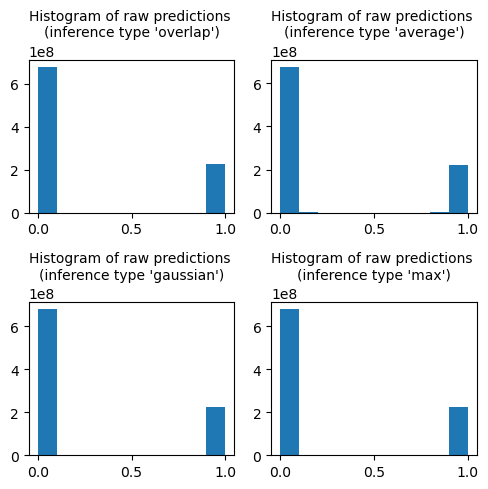

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))

for i, ax in zip(inference_types, axs.flatten()):
    # concatenate raw predictions
    raw_preds_concat = [preds_dict[sample_id][i] for sample_id in sample_ids]
    raw_preds_concat = np.concatenate(raw_preds_concat, axis=1)

    ax.hist(raw_preds_concat.flatten(), bins=10)
    ax.set_title(
        f"Histogram of raw predictions \n(inference type '{i}')", fontsize=10.0
    )

fig.tight_layout()

### code to try and visualize different types of inference

In [ ]:
# ## DEBUG ###

# test_dataset = SparkDataset(
#         base_path=dataset_path,
#         sample_ids=['34'],
#         testing=testing,
#         smoothing=c.get("dataset", "data_smoothing"),
#         step=c.getint("testing", "data_stride"),
#         #step=2,
#         duration=c.getint("testing", "data_duration"),
#         remove_background=c.get("dataset", "remove_background"),
#         temporal_reduction=c.getboolean(
#             "network", "temporal_reduction", fallback=False
#         ),
#         num_channels=c.getint("network", "num_channels", fallback=1),,
#         normalize_video=c.get("dataset", "norm_video"),
#         only_sparks=c.getboolean("dataset", "only_sparks", fallback=False),
#         sparks_type=c.get("dataset", "sparks_type"),
#         ignore_frames=c.getint("training", "ignore_frames_loss"),
#         ignore_index=4,
#         gt_available=True,
#         inference=inference,
#     )

# testing_dataloader = torch.utils.data.DataLoader(
#     test_dataset,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=0,
#     pin_memory=True,
# )

# from training_inference_tools import do_inference

# test_dataset.inference = 'overlap'
# pred_overlap = do_inference(network=network,
#                             test_dataset=test_dataset,
#                             test_dataloader=testing_dataloader,
#                             device=device,
#                             )


# test_dataset.inference = 'average'
# pred_average = do_inference(network=network,
#                             test_dataset=test_dataset,
#                             test_dataloader=testing_dataloader,
#                             device=device,
#                             )

# test_dataset.inference = 'max'
# pred_max = do_inference(network=network,
#                             test_dataset=test_dataset,
#                             test_dataloader=testing_dataloader,
#                             device=device,
#                             )

# test_dataset.inference = 'gaussian'
# pred_gaussian = do_inference(network=network,
#                             test_dataset=test_dataset,
#                             test_dataloader=testing_dataloader,
#                             device=device,
#                             )

# pred_overlap.shape, pred_average.shape, pred_max.shape, pred_gaussian.shape
# empty_vertical = np.ones((pred_overlap.shape[0],
#                           pred_overlap.shape[1],
#                           pred_overlap.shape[2],
#                           10))*0.5

# empty_horizontal = np.ones((pred_overlap.shape[0],
#                             pred_overlap.shape[1],
#                             10,
#                             2*pred_overlap.shape[3]+10))*0.5
# # stack the four predictions togheter in a squared grid

# stack1 = np.concatenate((pred_overlap, empty_vertical, pred_average), axis=3)
# stack2 = np.concatenate((pred_max, empty_vertical, pred_gaussian), axis=3)

# stack_all = np.concatenate((stack1, empty_horizontal, stack2), axis=2)
# import napari
# viewer = napari.Viewer()
# viewer.theme = 'dark'

# viewer.add_image(stack_all[0],
#                  name='background',
#                     #colormap='white',
#                     blending='additive',
#                     opacity=0.5,
#                     #visible=False,
#                 )

# viewer.add_image(stack_all[1],
#                     name='sparks',
#                     colormap='green',
#                     blending='additive',
#                     opacity=0.5,
#                     #visible=False,
#                 )

# viewer.add_image(stack_all[2],
#                     name='waves',
#                     colormap='yellow',
#                     blending='additive',
#                     opacity=0.5,
#                     #visible=False,
#                 )

# viewer.add_image(stack_all[3],
#                     name='puffs',
#                     colormap='red',
#                     blending='additive',
#                     opacity=0.5,
#                     #visible=False,
#                 )

### code to visualize a confusion matrix (OLD)

In [ ]:
# plt.rcParams.update({"font.size": 24})

# n_rows = 1
# n_cols = 1
# num_plots = n_rows * n_cols

# pad = 5  # in points

# fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 100))

# cols = ["IoU"]
# tick_labels = ["Background", "Sparks", "Waves", "Puffs"]

# for ax, col in zip(axs[0], cols):
#     ax.annotate(
#         col,
#         xy=(0.5, 1.2),
#         xytext=(0, pad),
#         xycoords="axes fraction",
#         textcoords="offset points",
#         size="large",
#         ha="center",
#         va="baseline",
#     )


# for ax, row in zip(axs[:, 0], ["TOT"] + movie_ids):
#     ax.annotate(
#         row,
#         xy=(0, 0.5),
#         xytext=(-ax.yaxis.labelpad - pad, 0),
#         xycoords=ax.yaxis.label,
#         textcoords="offset points",
#         size="large",
#         ha="right",
#         va="center",
#     )

# fig.suptitle("Confusion matrices", fontsize=36, y=1)


# # configure heatmap background
# colors = sns.color_palette(
#     ["white", "lightcoral", "paleturquoise", "lemonchiffon", "lightgreen"], as_cmap=True
# )
# colored_bg = [[0, 2, 2, 2], [1, 4, 3, 3], [1, 3, 4, 3], [1, 3, 3, 4]]

# # Get array with confusion matrices to be plotted
# cm_array = np.concatenate(
#     (
#         [[iou_confusion_matrix_tot, iomin_confusion_matrix_tot]],
#         [
#             [iou_confusion_matrix[sample_id], iomin_confusion_matrix[sample_id]]
#             for sample_id in movie_ids
#         ],
#     ),
#     axis=0,
# )

# for row_id in range(n_rows):
#     for col_id in range(n_cols):
#         cm = cm_array[row_id, col_id].astype(int).astype(str)

#         ax = axs[row_id, col_id]
#         sns.heatmap(
#             data=colored_bg,
#             cmap=colors,
#             annot=cm,
#             fmt="",
#             annot_kws={"fontsize": 36},
#             cbar=False,
#             square=True,
#             ax=ax,
#         )

#         ax.tick_params(length=0, labeltop=True, labelbottom=False)
#         ax.tick_params(axis="both", which="major", pad=16)

#         ax.set_xlabel("Predicted", labelpad=32)
#         ax.xaxis.set_label_position("top")
#         ax.set_xticklabels(tick_labels)
#         ax.add_patch(
#             plt.Rectangle(
#                 (-0.01, 1),
#                 1.01,
#                 0.1,
#                 color="yellow",
#                 clip_on=False,
#                 zorder=0,
#                 transform=ax.transAxes,
#             )
#         )

#         ax.set_ylabel("Actual Values", labelpad=32)
#         ax.set_yticklabels(tick_labels, rotation=90, va="center")
#         ax.add_patch(
#             plt.Rectangle(
#                 (0, 0),
#                 -0.1,
#                 1,
#                 color="yellow",
#                 clip_on=False,
#                 zorder=0,
#                 transform=ax.transAxes,
#             )
#         )

# # plt.subplots_adjust(hspace=0.005, wspace=0.)
# # plt.subplots_adjust(hspace=0.1, wspace=0.1, top=0.9, left=0.05, right=0.95)
# # fig.subplots_adjust(left=0.15, top=0.95)
# fig.subplots_adjust(wspace=1.5)
# plt.tight_layout()
# plt.savefig(os.path.join(out_dir, "all_confusion_matrices.png"))
# plt.show()